In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from numpy.polynomial.polynomial import polyfit, polyval
device = torch.device('cuda')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [3]:
from mgwr.kernels import Kernel
from spglm.iwls import _compute_betas_gwr

In [4]:
bw = 200
cotton_price = 0.4
nitrogen_cost = 1.0
nitrogen_ratio = nitrogen_cost/cotton_price
sq_rate = 100
sq_yield = 4500
rst_b2g = -0.02

In [5]:
trial = np.load('../data/Trial_Design.npy')
trial_names = np.load('../data/Trial_Design_names.npy', allow_pickle=True)
trial_coords = np.load('../data/Trial_Design_coords.npy')
trial_coords_idx = np.int0(np.floor(trial_coords/3))
n = trial_coords.shape[0]

rst_sim = np.load('../data/Trial_sim.npy')

In [6]:
idx = np.where(trial_names == 'size15_p100')[0][0]
idx

17

In [7]:
na_crit = ~np.isnan(trial[idx].reshape(-1))
trial_rst = np.nan_to_num(trial[idx])
coords = trial_coords[na_crit]
cidx = trial_coords_idx[na_crit]

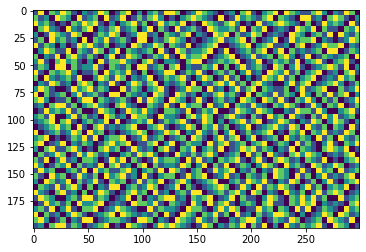

In [8]:
plt.imshow(trial_rst)


In [9]:
i = np.abs(coords - [450, 300]).sum(1).argmin()
wi = Kernel(i, trial_coords, bw, fixed=False, function='gaussian')
wi = wi.kernel.reshape(trial_rst.shape)
wic = wi[((wi > 0.008).sum(1) > 0)][:, ((wi > 0.008).sum(0) > 0)]

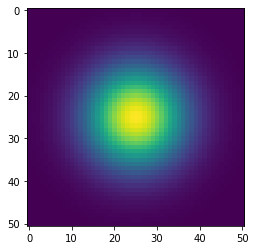

In [10]:
plt.imshow(wic)

In [100]:
b0_true = rst_sim[:100]
b1_true = rst_sim[:100]

rst_optr = sq_rate * (1 + 0.25 * b1_true) 
rst_optr = np.clip(rst_optr, 0, 200)

rst_b1 = -2 * rst_b2g * rst_optr + nitrogen_ratio
rst_b0 = sq_yield * (1 + 0.05 * b0_true)
rst_b0 = rst_b0 - (rst_b1 * rst_optr + rst_b2g * rst_optr **2) 

inp_rate = sq_rate + 12.5 * trial_rst
rst_yield_obs =  rst_b0 + rst_b1 * inp_rate + rst_b2g * inp_rate**2

y = rst_yield_obs.reshape(-1,1)
X = inp_rate.reshape(-1,1)

y_std = StandardScaler().fit(y)
y = y_std.transform(y).reshape(rst_yield_obs.shape)

X_std = StandardScaler().fit(X)
X = X_std.transform(X).reshape(inp_rate.shape)

p = np.array([0,1,2])[:,None,None]
X = X[None,None] ** (np.ones((3, *X.shape)) * p)


In [79]:
s = 44
b0_true = rst_sim[s]
b1_true = rst_sim[100 + s]


rst_optr = sq_rate * (1 + 0.25 * b1_true) 
rst_optr = np.clip(rst_optr, 0, 200)


rst_b1 = -2 * rst_b2g * rst_optr + nitrogen_ratio
rst_b0 = sq_yield * (1 + 0.05 * b0_true)
rst_b0 = rst_b0 - (rst_b1 * rst_optr + rst_b2g * rst_optr **2) 

inp_rate = sq_rate + 12.5 * trial_rst
rst_yield_obs =  rst_b0 + rst_b1 * inp_rate + rst_b2g * inp_rate**2

y = rst_yield_obs.reshape(-1,1)
X = inp_rate.reshape(-1,1)

y_std = StandardScaler().fit(y)
y = y_std.transform(y).reshape(rst_yield_obs.shape)

X_std = StandardScaler().fit(X)
X = X_std.transform(X).reshape(inp_rate.shape)

p = np.array([0,1,2])[:,None,None]
X = X[None,None] ** (np.ones((3, *X.shape)) * p)


In [80]:
W = torch.tensor(wic, device = device)[None,None]
W = W/W.sum()

In [81]:
c = np.zeros_like(X)
c[:,0] = y
c = torch.tensor(c, device = device, requires_grad = True)

In [82]:
X = torch.tensor(X, device = device)
y = torch.tensor(y, device = device)[None]

In [83]:
criterion = nn.MSELoss()

In [84]:
learning_rate = 0.1
optimizer = torch.optim.Adam((c,), learning_rate)

In [85]:
from livelossplot import PlotLosses
liveloss = PlotLosses()

In [86]:
for i in trange(100):
    # Limpa os gradientes
    optimizer.zero_grad()
    
    # Obtem o output
    cm = F.conv2d(c[0][:,None], W, stride = 1, padding = 25)[:,0][None]
    cm[:,2] = cm[:,2].mean()
    pred = (X * cm).sum(1)
    
    # Calcula a perda pela loss function
    loss = criterion(pred, y)
    loss += criterion(cm, c)
    
    # Obtem os gradientes
    loss.backward()

    # Atualiza os parâmetros
    optimizer.step()

    liveloss.update({
        'log loss': loss.item()
    })


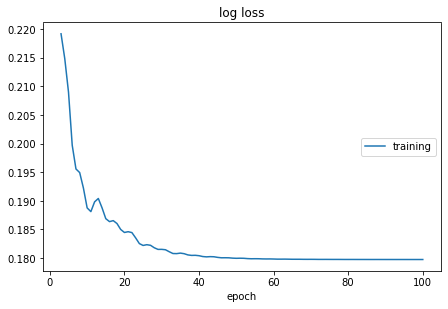

log loss:
training   (min:    0.180, max:    0.289, cur:    0.180)


In [87]:
liveloss.draw()

In [88]:
ypred = pred.data.cpu().numpy()[0]

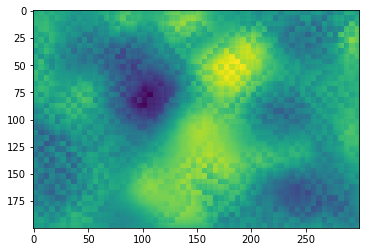

In [89]:
plt.imshow(ypred)

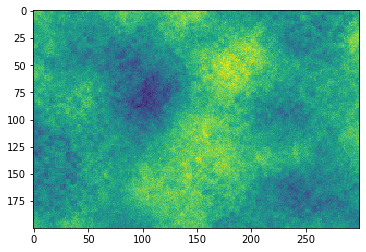

In [90]:
plt.imshow(rst_yield_obs)

In [91]:
X_testr = torch.linspace(0, 200, 200, device = device)
X_cost = X_testr[:,None,None] * nitrogen_cost
X_test = (X_testr - X_std.mean_[0]) /  X_std.scale_[0]
p = torch.tensor([[0,1,2]], device = device)[:,:,None,None]
X_test = X_test[:,None,None,None] ** (torch.ones_like(c) * p)

y_test = (X_test * cm).sum(1)
y_test = y_std.mean_[0] + (y_std.scale_[0] * y_test)
y_net_pred = y_test * cotton_price - X_cost

best_idx = y_net_pred.argmax(0)
rst_optr_pred = X_testr[best_idx]
rst_optr_pred = rst_optr_pred.cpu().numpy()

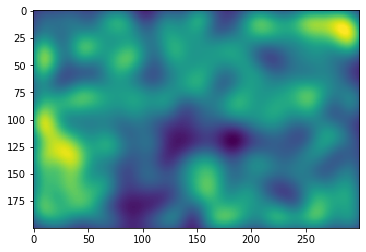

In [92]:
plt.imshow(rst_optr_pred)

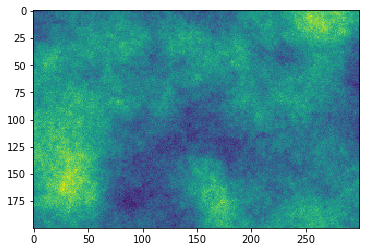

In [93]:
plt.imshow(rst_optr)

In [94]:
rst_optr.mean()
rst_optr_pred.mean()

97.71489

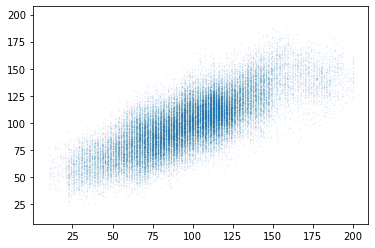

In [95]:
plt.scatter(rst_optr_pred.reshape(-1), rst_optr.reshape(-1), alpha=0.1, s = 0.1)

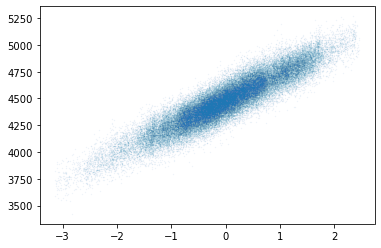

In [96]:
plt.scatter(ypred.reshape(-1), rst_yield_obs.reshape(-1), alpha=0.1, s = 0.1)